### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.  

Какой набор предложений можно считать лучшим?   
Какие метрики стоит проанализировать для принятия правильного решения и как?

In [4]:
# Импорт библиотек 

import numpy as np 
import pandas as pd
import plotly.express as px
import seaborn as sns
sns.set(font_scale=1.85, style="whitegrid",rc={'figure.figsize':(12, 6)})


from scipy import stats
from tqdm.auto import tqdm
import scipy.stats as stats

from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')


In [5]:
# прочитаем данные
data = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep = ';')

In [6]:
# посмотрим на данные 
data.shape

(404770, 3)

In [7]:
data.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [8]:
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Посмотрим как распределены чеки в обеих наших группах:

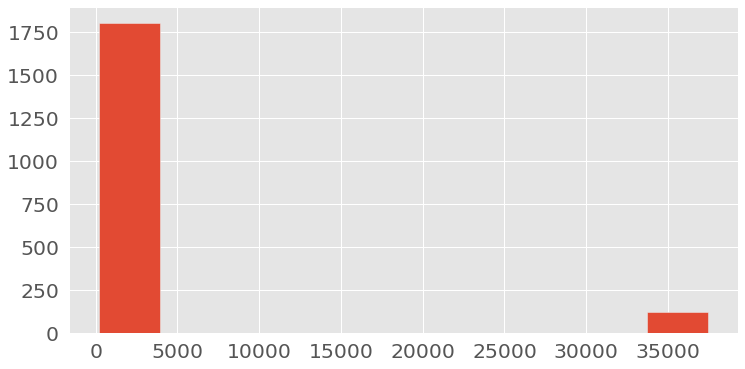

In [9]:
# группа а:

data.query('testgroup == "a" and revenue > 0 ').revenue.hist()

Из данной визуализации видно, что чеки в группе а распределны неравномерно и имеется значительный выброс в районе крупных чеков. 

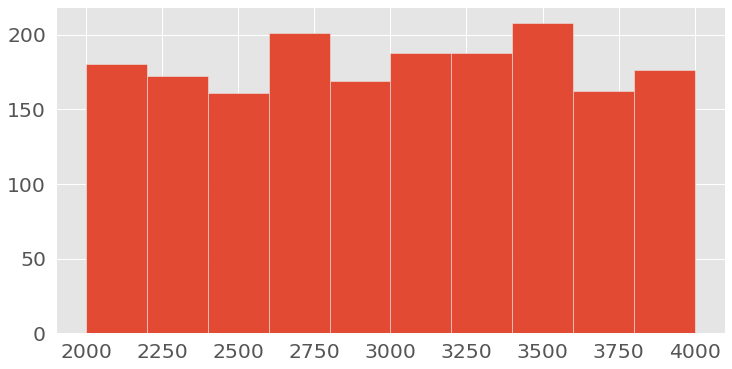

In [10]:
# группа b:

data.query('testgroup == "b" and revenue > 0 ').revenue.hist()

В группе b чеки распределены достаточно равномерно и лежат в диапозоне от 2000 до 4000.

Посмотрим на среднее значение по чекам в каждой из групп:

In [11]:
group_a_mean = data.query('testgroup == "a" and revenue > 0 ').revenue.mean()
group_b_mean = data.query('testgroup == "b" and revenue > 0 ').revenue.mean()
print('Средняя выручка на одного платящего пользователя в группе а:', round(group_a_mean))
print('Средняя выручка на одного платящего пользователя в группе b:', round(group_b_mean))

Средняя выручка на одного платящего пользователя в группе а: 2664.0
Средняя выручка на одного платящего пользователя в группе b: 3004.0


Интересно проверить, значимо ли отличаются средние значения выручек двух групп?  
Для этого воспользуемся bootstrap.

In [12]:
# объявим функцию 

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { 
            "quants": quants, 
            "p_value": p_value}

In [13]:
# Отберём данные 

group_a = data.query('testgroup == "a" and revenue > 0 ').revenue
group_b = data.query('testgroup == "b" and revenue > 0 ').revenue

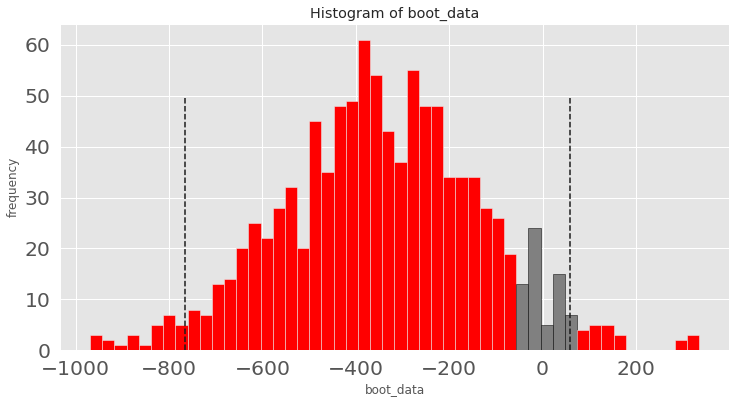

{'quants':                 0
 0.025 -766.027269
 0.975   59.854059,
 'p_value': 0.10505646238400387}

In [14]:
# Применим функцию:

get_bootstrap(group_a, group_b)

**Промежуточный вывод**: p-value для bootstrap оказалось больше 0.05, что при заданном уровне значимости (0.95) говорит об принятии нулевой гипотезы - равентстве средних значений в контрольной и тестовой группах. 

Выброс в группе a не даёт покоя.  
Посмотрим, как распределятся выручка, если убрать большие чеки:

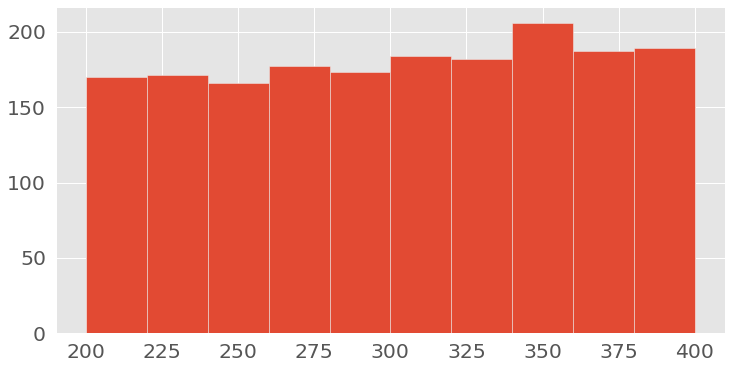

In [15]:
data.query('testgroup == "a" and 3000 > revenue > 0 ').revenue.hist()

Теперь распределение более-менее равномерное и лежит в диапозоне от 200 до 400.

In [21]:
count_small_chek_a = data.query('testgroup == "a" and 3000 > revenue > 0 ').revenue.count()
count_big_chek_a = data.query('testgroup == "a" and 3000 < revenue').revenue.count()
print('Число маленьких чеков (< 3000) в группе а:', count_small_chek_a)
print('Число больших чеков (> 3000) в группе а:', count_big_chek_a)

Число маленьких чеков (< 3000) в группе а: 1805
Число больших чеков (> 3000) в группе а: 123


Интересно посмотреть на число всех чеков в группе b:

In [22]:
count_chek_b = data.query('testgroup == "b" and revenue > 0 ').revenue.count()
print('Число всех чеков в группе b:', count_chek_b)

Число всех чеков в группе b: 1805


**Теперь выброс в группе а выглядит как случайно добавленные данные!**

In [24]:
# Снова сравним средние выручки по группам, но без выброса в группе a: 
group_a_mean = data.query('testgroup == "a" and 3000 > revenue > 0 ').revenue.mean()
group_b_mean = data.query('testgroup == "b" and revenue > 0 ').revenue.mean()
print('Средняя выручка на одного платящего пользователя в группе а:', round(group_a_mean))
print('Средняя выручка на одного платящего пользователя в группе b:', round(group_b_mean))

Средняя выручка на одного платящего пользователя в группе а: 302.0
Средняя выручка на одного платящего пользователя в группе b: 3004.0


Ого! Средние чеки отличаются на порядок!  
Конечно, исходя из распределения выручек и зная их средние можно с уверенностью сказать, что это различие значимо. Но для подтверждения снова применим bootstrap:

In [25]:
# Обновлённые данные:

group_a_new = data.query('testgroup == "a" and 3000 >revenue > 0 ').revenue
group_b_new = data.query('testgroup == "b" and revenue > 0 ').revenue

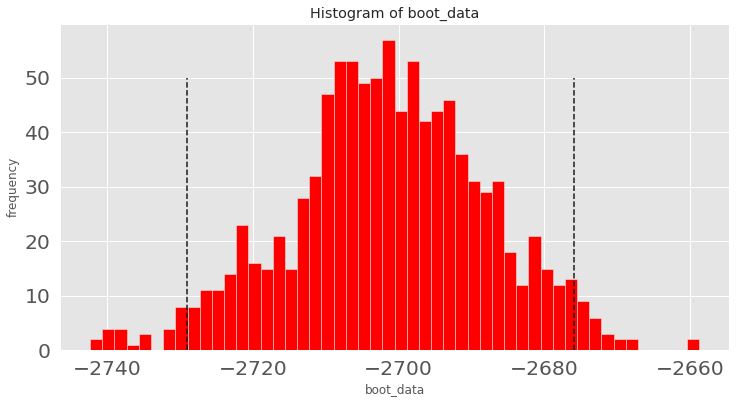

{'quants':                  0
 0.025 -2729.099654
 0.975 -2675.882479,
 'p_value': 0.0}

In [26]:
# Применим функцию: 

get_bootstrap(group_a_new, group_b_new)

**Промежуточный вывод 2**: Что и требовалось доказать. p-value для bootstrap оказалось меньше 0.05, что при заданном уровне значимости (0.95) говорит об отклонении нулевой гипотезы о равенстве средних значений. 

Теперь, убрав случайный выброс, рассчитаем ключевые метрики

In [27]:
data_group_a = data.query('testgroup == "a" and 3000 > revenue ')
data_group_b = data.query('testgroup == "b"')

In [28]:
# Посчитаем ARPU (средний доход на одного клиента):

ARPU_a = data_group_a.revenue.sum() / data_group_a.revenue.count()

print('ARPU в контрольной группе:', round(ARPU_a))

ARPU_b = data_group_b.revenue.sum() / data_group_b.revenue.count()

print('ARPU в тестовой группе:', round(ARPU_b))

ARPU в контрольной группе: 3.0
ARPU в тестовой группе: 27.0


In [29]:
# Посчитаем ARPPU (cредняя выручка на одного платящего пользователя):

ARPPU_a = round(data_group_a.revenue.sum() / data_group_a.query('revenue != 0').revenue.count())

print('ARPPU в контрольной группе:', ARPPU_a)

ARPPU_b = round(data_group_b.revenue.sum() / data_group_b.query('revenue != 0').revenue.count())

print('ARPPU в тестовой группе:', ARPPU_b)

ARPPU в контрольной группе: 302.0
ARPPU в тестовой группе: 3004.0


In [30]:
# Найдём долю платящих в каждой группе:

share_of_paying_a = round(100 * data_group_a.query('revenue != 0').revenue.count() / data_group_a.revenue.count(), 2)
print('Доля платящих в контрольной группе:', share_of_paying_a,'%')
share_of_paying_b = round(100 * data_group_b.query('revenue != 0').revenue.count() / data_group_b.revenue.count(), 2)
print('Доля платящих в тестовой группе:', share_of_paying_b,'%')

Доля платящих в контрольной группе: 0.89 %
Доля платящих в тестовой группе: 0.89 %


In [31]:
# Доход с каждой группы:

total_revenue_a = data_group_a.revenue.sum()
total_revenue_b = data_group_b.revenue.sum()


print('Доход с группы А:', total_revenue_a)
print('Доход с группы B:', total_revenue_b)

Доход с группы А: 545937
Доход с группы B: 5421603


In [32]:
d = {'ARPU' : [ARPU_a, ARPU_b],
     'ARPPU' : [ARPPU_a, ARPPU_b],
     'Доля платящих, %' : [share_of_paying_a, share_of_paying_b],
     'Полный доход' : [total_revenue_a, total_revenue_b]}
df = pd.DataFrame(data = d, index= ['A', 'B'])


df.style.format({'ARPU': "{:.2f}", 'ARPPU': '{:.0f}', 'Доля платящих, %' : '{:.2f}', 'Полный доход' : '{:.0f}'})


,ARPU,ARPPU,"Доля платящих, %",Полный доход
A,2.70,302,0.89,545937
B,26.75,3004,0.89,5421603


### Вывод:

Скорее всего выброс с очень большими чеками в группе a - был случайностью, которая приводила к выводу о том, что средняя выручка двух групп значимо не отличается.
Почистив данные оказалось, что в обеих группах одинаковое число платящих пользователей и средние значения выручек сильно разнится между группами.
По рассчитанным метрикам можно сделать вывод о большом преимуществе набора акционных предложений в тестовой группе, именно этот вариант можно считать наилучшим.